In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
claim_data = pd.read_csv(r"C:\Users\Admin\Downloads\New folder\Case Study 3 - Insurance Claims Case Study\claims.csv")
cust_data = pd.read_csv(r"C:\Users\Admin\Downloads\New folder\Case Study 3 - Insurance Claims Case Study\cust_demographics.csv")

In [9]:
cust_data.rename(columns={'CUST_ID':'customer_id'},inplace=True) ## Changed name so that we can join perfectly

In [10]:
cust_claim=pd.merge(claim_data,cust_data,on='customer_id',how='inner') ## Merged cust_data and claim_data

In [11]:
# Datatype change according to bussiness:-

cust_claim[['claim_id','customer_id']]=cust_claim[['claim_id','customer_id']].astype('object')

In [12]:
cust_claim['claim_date']=pd.to_datetime(cust_claim['claim_date'])

In [13]:
cust_claim['DateOfBirth']=pd.to_datetime(cust_claim['DateOfBirth'])

In [14]:
cust_claim['claim_amount']=cust_claim['claim_amount'].str.replace('$','',regex=True).astype(float)

In [15]:
cust_claim['alert_flag']=cust_claim['police_report'].apply(lambda x:1 if x in ['No','Unknown'] else 0)

In [16]:
cust_claim.sort_values(by='claim_date',ascending=False,inplace=True)

In [17]:
cust_claim.drop_duplicates(subset='customer_id',keep='first',inplace=True)

In [18]:
# Fill the continue missing value with mean
cust_claim['claim_amount'].fillna(cust_claim['claim_amount'].mean(),inplace=True) 

In [19]:
## Fill the categorical missing value by mode
cust_claim['total_policy_claims'].fillna(cust_claim['total_policy_claims'].mode()[0],inplace=True)

In [20]:
cust_claim.isnull().sum().sum()

0

In [21]:
from datetime import datetime

In [22]:
crnt_dte=datetime.now()

In [23]:
## Making Age columns

cust_claim['Age']=(crnt_dte-cust_claim['DateOfBirth']).dt.days 

cust_claim['Age']=cust_claim['Age'].apply(lambda x:0 if x<0 else x)

cust_claim['Age']=round(cust_claim['Age']/365).astype(int)

In [24]:
## Divide the customers in age groups

bins=[0,18,30,60,100]

cust_claim['Age_group']=pd.cut(cust_claim['Age'],bins=bins,labels=['Under 18','18-30','30-60','Over 60'],include_lowest=True)

In [25]:
avg_amt=round(cust_claim.groupby('Segment')['claim_amount'].mean()).reset_index()
print('The average amount claimed by the customers from various segments:-')
avg_amt

The average amount claimed by the customers from various segments:-


,Segment,claim_amount
0,Gold,12846.0
1,Platinum,12372.0
2,Silver,12268.0


In [26]:
before=pd.to_datetime('2018-10-01') - pd.DateOffset(days=20) # Derive the dates before 20 days from 1st oct 2018

In [27]:
at_least_20 = cust_claim[cust_claim['claim_date']<=before] # Filter the data on the basis of condition

In [28]:
print('The total amount claimed at least 20 days prior to 1st October,2018:-')
round(at_least_20.groupby('incident_cause')['claim_amount'].sum()).reset_index()

The total amount claimed at least 20 days prior to 1st October,2018:-


,incident_cause,claim_amount
0,Crime,721939.0
1,Driver error,3315851.0
2,Natural causes,1312987.0
3,Other causes,3723152.0
4,Other driver error,3277536.0


In [29]:
gen=round(cust_claim.groupby(['gender','Segment'])['claim_amount'].sum())

Text(0.5, 1.0, 'Claim Amount by Gender and Segment')

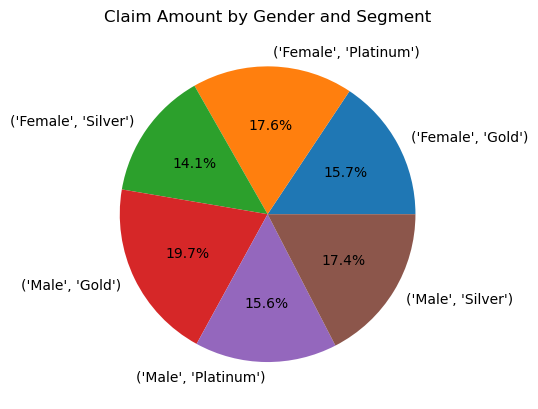

In [30]:
plt.pie(gen.values,labels=gen.index,autopct='%1.1f%%')
plt.title('Claim Amount by Gender and Segment')

In [31]:
mal=cust_claim[cust_claim['incident_cause'].isin( ['Driver error','Other driver error'])]

C:\Users\Admin\AppData\Local\Temp\ipykernel_7980\2909350070.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(round(cust_claim['claim_amount']))


Text(0.5, 1.0, 'Gender Wise Claim in driver related issues')

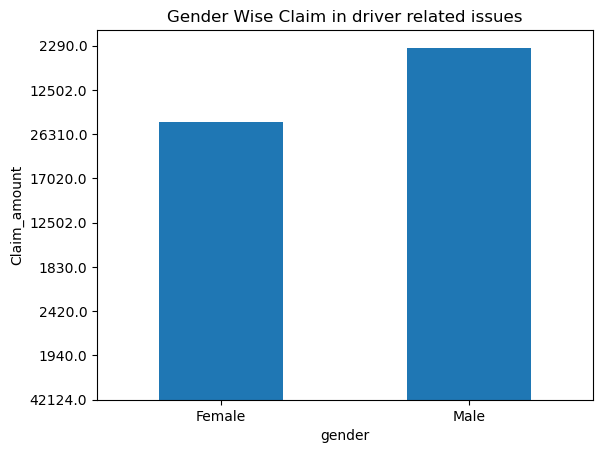

In [32]:
round(mal.groupby('gender')['claim_amount'].sum()).plot(kind='bar')
plt.xticks(rotation=360)
plt.gca().set_yticklabels(round(cust_claim['claim_amount']))
plt.ylabel('Claim_amount')
plt.title('Gender Wise Claim in driver related issues')

Text(0.5, 1.0, 'Age_group wise fraudulent count')

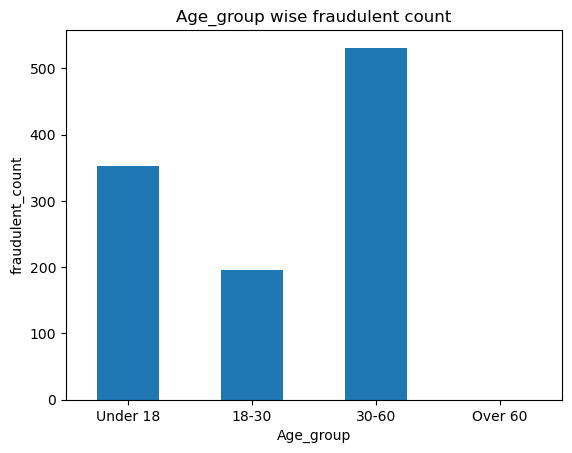

In [33]:
cust_claim.groupby('Age_group')['fraudulent'].count().plot(kind='bar')
plt.xticks(rotation=360)
plt.ylabel('fraudulent_count')
plt.title('Age_group wise fraudulent count')

In [34]:
cust_claim['Month']=cust_claim['claim_date'].dt.month # assign a month column

Text(0.5, 1.0, 'Monthly Trend for claim amount')

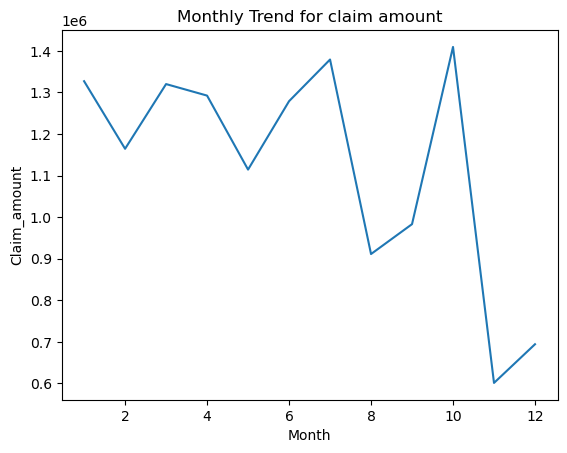

In [35]:
round(cust_claim.groupby('Month')['claim_amount'].sum()).plot(kind='line')
plt.ylabel('Claim_amount')
plt.title('Monthly Trend for claim amount')

In [36]:
avg_claim_amount=cust_claim.groupby(['gender', 'Age_group', 'fraudulent'])['claim_amount'].mean().reset_index()


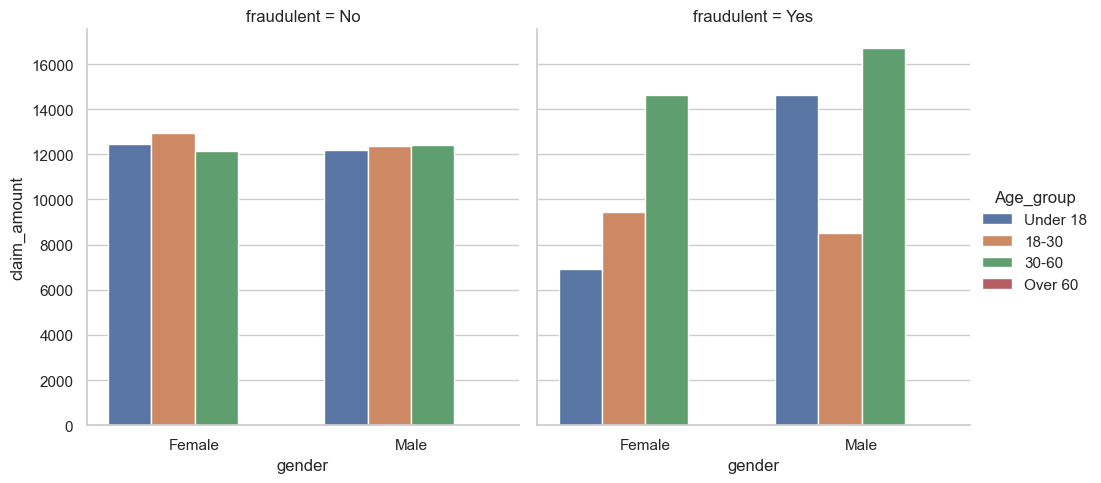

In [37]:
sns.set(style="whitegrid")
g = sns.catplot(
    data=avg_claim_amount, kind="bar",
    x="gender", y="claim_amount", hue="Age_group", col="fraudulent",
)

# Hypothesis Testing

In [38]:
import scipy.stats as stats

from scipy.stats import chi2_contingency

from scipy.stats import ttest_1samp

from scipy.stats import f_oneway

from scipy.stats import pearsonr

In [39]:
## Perform two sample t-test

# gender  wise claim

fem=cust_claim[['gender','claim_amount']]
Male_wise=fem[fem['gender']=='Male']['claim_amount']
Female_wise=fem[fem['gender']=='Female']['claim_amount']


In [40]:
# Null Hypothesis(H0):- There is no significance difference in the claimed amount

# Alternate Hypothesis(H1):- There is not any significance difference in the claimed amount


t_stat,p_value = stats.ttest_ind(Male_wise,Female_wise)

In [41]:
alpha =0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('There is a statistically significant difference in claim amounts between males and females.')
else:
    print('There is no statistically significant difference in claim amounts between males and females.  ')

There is no statistically significant difference in claim amounts between males and females.  


In [42]:
## For this analysis perform chi-square test

In [43]:
contingency_table = pd.crosstab(cust_claim['Age_group'],cust_claim['Segment'])

In [44]:
## Null Hypothesis(H0):- There is no relationship between 'age group' and 'segment'

## Alternate Hypothesis(H1):- There is relationship between 'age group' and 'segment'

chi2, p, dof, expected=chi2_contingency(contingency_table)

alpha1=0.05

In [45]:
if p < alpha:
    print('Reject the null hypothesis: There is a relationship between age category and segment.')
else:
    print('Fail to reject the null hypothesis: There is no relationship between age category and segment')

Fail to reject the null hypothesis: There is no relationship between age category and segment


In [46]:
## Null Hypothesis(H0):- The current year's claim amounts are not significantly different

## Alternate Hypothesis(H1):- The current year's claim amounts are signicantly different

pop_mean = 10000

t_test2,p_value2 = ttest_1samp(cust_claim['claim_amount'],pop_mean)

alpha2 = 0.05

if p_value2 < alpha2:
    print('Reject the null hypothesis: There is a significant rise in the claim amounts.')
else:
    print('Fail to reject the null hypothesis: Claim amounts are not significantly different')

Reject the null hypothesis: There is a significant rise in the claim amounts.


In [47]:
cust_claim['Age_group'].value_counts()

30-60       531
Under 18    352
18-30       195
Over 60       0
Name: Age_group, dtype: int64

In [48]:
    Adult=cust_claim.loc[cust_claim.Age_group=='30-60','claim_amount']
    Child=cust_claim.loc[cust_claim.Age_group=='Under 18','claim_amount'] 
    Teenage=cust_claim.loc[cust_claim.Age_group=='18-30','claim_amount']
    

In [49]:
## Perform Annova Test

## Null Hypothesis(H0): There is no significant difference

## Alternate Hypothesis(H1): There is at least one group is different from others

f_statistic, p_value4=stats.f_oneway(Adult,Child,Teenage)

alpha4 = 0.05

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in insurance claims among age groups.")
else:
    print("Fail to reject the null hypothesis: No significant difference in insurance claims among age groups.")

Fail to reject the null hypothesis: No significant difference in insurance claims among age groups.


In [50]:
## Perform Pearsonr correlation test

## Null Hypothesis(H0):- There is no significant relation
## Alternate Hypothesis(H1):- There is signicant relation


r,p_value9=pearsonr(cust_claim['total_policy_claims'],cust_claim['claim_amount'])

alpha9=0.05

if p_value9 < alpha9:
    print("Reject the null hypothesis: There is a significant correlation between total claims and claimed amount.")
else:
    print("Fail to reject the null hypothesis: No significant correlation between total claims and claimed amount.")

Fail to reject the null hypothesis: No significant correlation between total claims and claimed amount.
